In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase

In [2]:
from codebase import volume_pipeline

In [3]:
res_shp = codebase.load_data.load_GRanD()

In [4]:
res_ref = codebase.load_data.load_formatted_usbr_data('mead')
res_ref_M = res_ref.resample('M').mean()
res_ref_elev = res_ref_M['Lake/Reservoir Elevation [ft]']
res_ref_M.columns

Index(['Lake/Reservoir Elevation [ft]', 'Lake/Reservoir Release - Total [af]',
       'Lake/Reservoir Release - Total [cfs]', 'Lake/Reservoir Storage [af]'],
      dtype='object', name='Variable')

In [5]:
# Volume pipeline with crs projection
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('hoover',res_shp,epsg_code=54017)
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

In [22]:
# Grab height from volume pipeline
height_array = volume_pipeline.calculate_height_time_series_from_start_and_change_in_DEM(
        dem_DA, fw_DA, fw_diff_DA, change_cond_DA) * change_cond_DA.values
height_series = pd.Series(index = fw_diff_DA['time'], data = height_array)

height_series

2018-09-01    26.579815
2018-10-01   -29.867916
2018-11-01   -26.055798
2018-12-01   -46.700557
2019-01-01    24.963727
2019-02-01   -31.357370
2019-03-01    25.116026
2019-04-01    36.779771
2019-05-01   -24.629435
2019-06-01   -30.032312
2019-07-01   -29.296021
2019-08-01   -27.896889
2019-09-01   -24.068139
2019-10-01    23.512213
2019-11-01   -25.896556
2019-12-01    12.594205
2020-01-01    32.327466
2020-02-01    27.888988
2020-03-01   -18.336823
2020-04-01    15.807146
2020-05-01    -9.236856
2020-06-01    14.840127
2020-07-01    30.459222
2020-08-01   -22.075784
2020-09-01    25.901448
2020-10-01   -48.330471
2020-11-01   -21.065859
2020-12-01    20.177184
2021-01-01    28.107054
2021-02-01    30.671269
2021-03-01   -27.393209
2021-04-01    29.155770
2021-05-01   -27.094165
2021-06-01   -14.042631
2021-07-01   -25.209978
2021-08-01   -35.273166
2021-09-01    22.539179
2021-10-01   -30.874583
2021-11-01    28.067542
2021-12-01   -20.474252
2022-01-01    11.137345
2022-02-01   -12

In [27]:
res_ref_elev

Datetime (UTC)
2018-01-31    1084.928710
2018-02-28    1087.872500
2018-03-31    1088.125161
2018-04-30    1086.301333
2018-05-31    1082.336452
                 ...     
2022-09-30    1044.374667
2022-10-31    1045.755806
2022-11-30    1044.292667
2022-12-31    1043.776452
2023-01-31    1044.910000
Freq: M, Name: Lake/Reservoir Elevation [ft], Length: 61, dtype: float64

In [23]:
ref_height_m = res_ref_elev.diff()[1:]/3.28

In [24]:
height_series_match ,res_ref_elev_match = codebase.time_series_calcs.intersecting_timeframes(height_series,ref_height_m)

In [25]:
mn = res_ref_elev_match.index[0].timestamp()*1e9
mx = res_ref_elev_match.index[-1].timestamp()*1e9

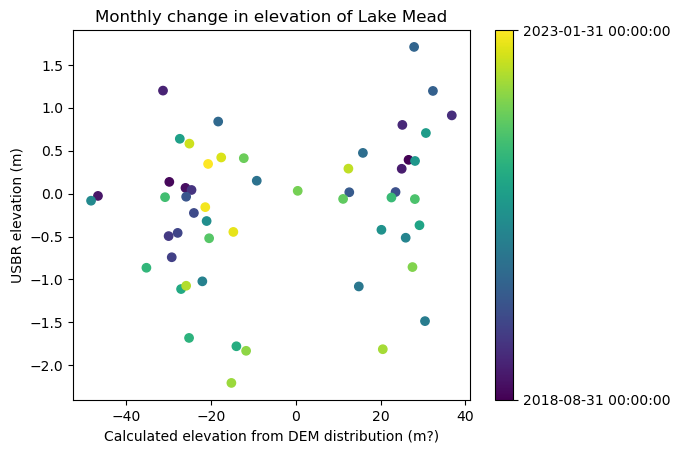

In [29]:
# Comparison of ref and calculated heights
plt.scatter(height_series_match ,res_ref_elev_match,c=res_ref_elev_match.index,vmin=mn, vmax=mx)
cbar = plt.colorbar()
cbar.set_ticks([mn,mx])
cbar.set_ticklabels([res_ref_elev_match.index[0],res_ref_elev_match.index[-1]])
plt.xlabel('Calculated elevation from DEM distribution (m?)')
plt.ylabel('USBR elevation (m)')
plt.title('Monthly change in elevation of Lake Mead');

Conclusion: DEM extraction is currently not a good match to reference elevation series.

<Axes: >

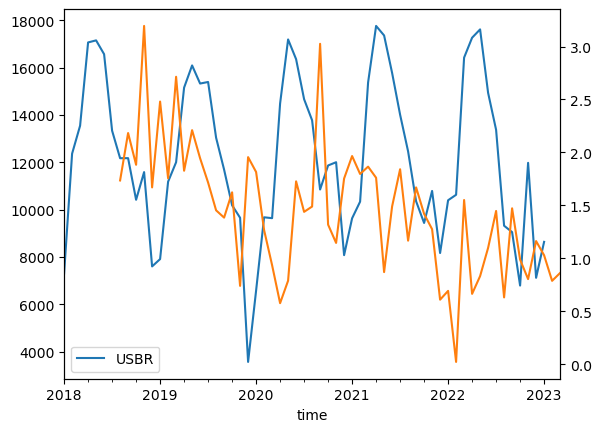

In [9]:
res_ref_M.plot(y='Lake/Reservoir Release - Total [cfs]', label='USBR')
test_vol.to_dataframe()['Watermask'].plot(label='Experimental',secondary_y= True)

In [ ]:
fw_diff_DA.isel(time=1).plot(cmap='RdBu')